In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

split_char = '/'

['cat-and-dog-breeds-parameters', 'xlearn', 'densenet121weights', 'fasttext-english-word-vectors-including-subwords', 'kerascatvsdog', 'petfinder-adoption-prediction']


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from math import sqrt
from sklearn.metrics import cohen_kappa_score as kappa_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.metrics import mean_squared_error
import scipy as sp
from skimage import feature
from collections import defaultdict
from collections import Counter
import operator
import cv2
from scipy.stats import itemfreq
from joblib import Parallel, delayed
import json
import string
from sklearn.model_selection import StratifiedKFold, GroupKFold
from PIL import Image as IMG
from PIL import Image
import glob
kappa_scorer = None

import os
os.environ['USER'] = 'root'
os.system('pip install ../input/xlearn/xlearn/xlearn-0.40a1/')

print(os.listdir("../input"))
print(os.listdir("../input/petfinder-adoption-prediction/"))
print(os.listdir("../input/petfinder-adoption-prediction/train"))
print(os.listdir("../input/petfinder-adoption-prediction/test"))

['cat-and-dog-breeds-parameters', 'xlearn', 'densenet121weights', 'fasttext-english-word-vectors-including-subwords', 'kerascatvsdog', 'petfinder-adoption-prediction']
['train', 'test', 'breed_labels.csv', 'train_sentiment', 'test_sentiment', 'test_metadata', 'train_images', 'train_metadata', 'state_labels.csv', 'color_labels.csv', 'test_images']
['train.csv']
['sample_submission.csv', 'test.csv']


In [4]:
train_df = pd.read_csv("../input/petfinder-adoption-prediction/train/train.csv")
test_df = pd.read_csv("../input/petfinder-adoption-prediction/test/test.csv")

In [5]:
y = train_df["AdoptionSpeed"]

In [6]:
labels_breed = pd.read_csv('../input/petfinder-adoption-prediction/breed_labels.csv')

In [7]:
with open('../input/cat-and-dog-breeds-parameters/rating.json', 'r') as f:
    ratings = json.load(f)
cat_ratings = ratings['cat_breeds']
dog_ratings = ratings['dog_breeds']
breed_id = {}

In [8]:
pet_attributes = set(list(cat_ratings["Abyssinian"].keys()) + list(dog_ratings["German Shepherd Dog"].keys()))

In [9]:
for i in pet_attributes:
    train_df[i] = 0
    test_df[i] = 0

In [10]:
cat_ratings = {k.lower(): v for k, v in cat_ratings.items()}
dog_ratings = {k.lower(): v for k, v in dog_ratings.items()}

In [11]:
for id,name in zip(labels_breed.BreedID,labels_breed.BreedName):
    breed_id[id] = str(name).lower()

In [12]:
for id,name in zip(labels_breed.BreedID,labels_breed.BreedName):
    breed_id[id] = str(name).lower()
breed_names_1 = [i for i in cat_ratings.keys()]
breed_names_2 = [i for i in dog_ratings.keys()]
def breed_name(df):
    for i, id in enumerate(df['Breed1']):
        if id in breed_id.keys(): 
            name = str(breed_id[id]).lower() 
            if name in breed_names_1:
                #print(cat_ratings[name])
                for key in cat_ratings[name].keys():
                    #print(key)
                    df.loc[i, key] = cat_ratings[name][key]
            if name in breed_names_2:
                #print(dog_ratings[name])
                for key in dog_ratings[name].keys():

                    df.loc[i, key] = dog_ratings[name][key]
        return df

In [15]:
import glob

In [16]:
train_image_files = sorted(glob.glob('../input/petfinder-adoption-prediction/train_images/*.jpg'))
train_metadata_files = sorted(glob.glob('../input/petfinder-adoption-prediction/train_metadata/*.json'))
train_sentiment_files = sorted(glob.glob('../input/petfinder-adoption-prediction/train_sentiment/*.json'))

print('num of train images files: {}'.format(len(train_image_files)))
print('num of train metadata files: {}'.format(len(train_metadata_files)))
print('num of train sentiment files: {}'.format(len(train_sentiment_files)))


test_image_files = sorted(glob.glob('../input/petfinder-adoption-prediction/test_images/*.jpg'))
test_metadata_files = sorted(glob.glob('../input/petfinder-adoption-prediction/test_metadata/*.json'))
test_sentiment_files = sorted(glob.glob('../input/petfinder-adoption-prediction/test_sentiment/*.json'))

print('num of test images files: {}'.format(len(test_image_files)))
print('num of test metadata files: {}'.format(len(test_metadata_files)))
print('num of test sentiment files: {}'.format(len(test_sentiment_files)))

num of train images files: 58311
num of train metadata files: 58311
num of train sentiment files: 14442
num of test images files: 14465
num of test metadata files: 14465
num of test sentiment files: 3865


In [17]:
# Images:
train_df_ids = train_df[['PetID']]
print(train_df_ids.shape)

train_df_imgs = pd.DataFrame(train_image_files)
train_df_imgs.columns = ['image_filename']
train_imgs_pets = train_df_imgs['image_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
train_df_imgs = train_df_imgs.assign(PetID=train_imgs_pets)
print(len(train_imgs_pets.unique()))

pets_with_images = len(np.intersect1d(train_imgs_pets.unique(), train_df_ids['PetID'].unique()))
print('fraction of pets with images: {:.3f}'.format(pets_with_images / train_df_ids.shape[0]))

# Metadata:
train_df_ids = train_df[['PetID']]
train_df_metadata = pd.DataFrame(train_metadata_files)
train_df_metadata.columns = ['metadata_filename']
train_metadata_pets = train_df_metadata['metadata_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
train_df_metadata = train_df_metadata.assign(PetID=train_metadata_pets)
print(len(train_metadata_pets.unique()))

pets_with_metadatas = len(np.intersect1d(train_metadata_pets.unique(), train_df_ids['PetID'].unique()))
print('fraction of pets with metadata: {:.3f}'.format(pets_with_metadatas / train_df_ids.shape[0]))

# Sentiment:
train_df_ids = train_df[['PetID']]
train_df_sentiment = pd.DataFrame(train_sentiment_files)
train_df_sentiment.columns = ['sentiment_filename']
train_sentiment_pets = train_df_sentiment['sentiment_filename'].apply(lambda x: x.split('/')[-1].split('.')[0])
train_df_sentiment = train_df_sentiment.assign(PetID=train_sentiment_pets)
print(len(train_sentiment_pets.unique()))

pets_with_sentiments = len(np.intersect1d(train_sentiment_pets.unique(), train_df_ids['PetID'].unique()))
print('fraction of pets with sentiment: {:.3f}'.format(pets_with_sentiments / train_df_ids.shape[0]))

(14993, 1)
14652
fraction of pets with images: 0.977
14652
fraction of pets with metadata: 0.977
14442
fraction of pets with sentiment: 0.963


In [18]:
# Images:
test_df_ids = test_df[['PetID']]
print(test_df_ids.shape)

test_df_imgs = pd.DataFrame(test_image_files)
test_df_imgs.columns = ['image_filename']
test_imgs_pets = test_df_imgs['image_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
test_df_imgs = test_df_imgs.assign(PetID=test_imgs_pets)
print(len(test_imgs_pets.unique()))

pets_with_images = len(np.intersect1d(test_imgs_pets.unique(), test_df_ids['PetID'].unique()))
print('fraction of pets with images: {:.3f}'.format(pets_with_images / test_df_ids.shape[0]))


# Metadata:
test_df_ids = test_df[['PetID']]
test_df_metadata = pd.DataFrame(test_metadata_files)
test_df_metadata.columns = ['metadata_filename']
test_metadata_pets = test_df_metadata['metadata_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
test_df_metadata = test_df_metadata.assign(PetID=test_metadata_pets)
print(len(test_metadata_pets.unique()))

pets_with_metadatas = len(np.intersect1d(test_metadata_pets.unique(), test_df_ids['PetID'].unique()))
print('fraction of pets with metadata: {:.3f}'.format(pets_with_metadatas / test_df_ids.shape[0]))



# Sentiment:
test_df_ids = test_df[['PetID']]
test_df_sentiment = pd.DataFrame(test_sentiment_files)
test_df_sentiment.columns = ['sentiment_filename']
test_sentiment_pets = test_df_sentiment['sentiment_filename'].apply(lambda x: x.split('/')[-1].split('.')[0])
test_df_sentiment = test_df_sentiment.assign(PetID=test_sentiment_pets)
print(len(test_sentiment_pets.unique()))

pets_with_sentiments = len(np.intersect1d(test_sentiment_pets.unique(), test_df_ids['PetID'].unique()))
print('fraction of pets with sentiment: {:.3f}'.format(pets_with_sentiments / test_df_ids.shape[0]))


# are distributions the same?
print('images and metadata distributions the same? {}'.format(
    np.all(test_metadata_pets == test_imgs_pets)))

(3972, 1)
3858
fraction of pets with images: 0.971
3858
fraction of pets with metadata: 0.971
3865
fraction of pets with sentiment: 0.973
images and metadata distributions the same? True


In [19]:
class PetFinderParser(object):
    
    def __init__(self, debug=False):
        
        self.debug = debug
        self.sentence_sep = ' '
        
        # Does not have to be extracted because main DF already contains description
        self.extract_sentiment_text = False
        
        
    def open_metadata_file(self, filename):
        """
        Load metadata file.
        """
        with open(filename, 'r', encoding='utf-8') as f:
            metadata_file = json.load(f)
        return metadata_file
            
    def open_sentiment_file(self, filename):
        """
        Load sentiment file.
        """
        with open(filename, 'r', encoding='utf-8') as f:
            sentiment_file = json.load(f)
        return sentiment_file
            
    def open_image_file(self, filename):
        """
        Load image file.
        """
        image = np.asarray(Image.open(filename))
        return image
        
    def parse_sentiment_file(self, file):
        """
        Parse sentiment file. Output DF with sentiment features.
        """
        
        file_sentiment = file['documentSentiment']
        file_entities = [x['name'] for x in file['entities']]
        file_entities = self.sentence_sep.join(file_entities)

        if self.extract_sentiment_text:
            file_sentences_text = [x['text']['content'] for x in file['sentences']]
            file_sentences_text = self.sentence_sep.join(file_sentences_text)
        file_sentences_sentiment = [x['sentiment'] for x in file['sentences']]
        
        file_sentences_sentiment = pd.DataFrame.from_dict(
            file_sentences_sentiment, orient='columns').sum()
        file_sentences_sentiment = file_sentences_sentiment.add_prefix('document_').to_dict()
        
        file_sentiment.update(file_sentences_sentiment)
        
        df_sentiment = pd.DataFrame.from_dict(file_sentiment, orient='index').T
        if self.extract_sentiment_text:
            df_sentiment['text'] = file_sentences_text
            
        df_sentiment['entities'] = file_entities
        df_sentiment = df_sentiment.add_prefix('sentiment_')
        
        return df_sentiment
    
    def parse_metadata_file(self, file):
        """
        Parse metadata file. Output DF with metadata features.
        """
        
        file_keys = list(file.keys())
        
        if 'labelAnnotations' in file_keys:
            file_annots = file['labelAnnotations'][:int(len(file['labelAnnotations']) * 0.3)]
            file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
            file_top_desc = [x['description'] for x in file_annots]
        else:
            file_top_score = np.nan
            file_top_desc = ['']
        
        file_colors = file['imagePropertiesAnnotation']['dominantColors']['colors']
        file_crops = file['cropHintsAnnotation']['cropHints']

        file_color_score = np.asarray([x['score'] for x in file_colors]).mean()
        file_color_pixelfrac = np.asarray([x['pixelFraction'] for x in file_colors]).mean()

        file_crop_conf = np.asarray([x['confidence'] for x in file_crops]).mean()
        
        if 'importanceFraction' in file_crops[0].keys():
            file_crop_importance = np.asarray([x['importanceFraction'] for x in file_crops]).mean()
        else:
            file_crop_importance = np.nan

        df_metadata = {
            'annots_score': file_top_score,
            'color_score': file_color_score,
            'color_pixelfrac': file_color_pixelfrac,
            'crop_conf': file_crop_conf,
            'crop_importance': file_crop_importance,
            'annots_top_desc': self.sentence_sep.join(file_top_desc)
        }
        
        df_metadata = pd.DataFrame.from_dict(df_metadata, orient='index').T
        df_metadata = df_metadata.add_prefix('metadata_')
        
        return df_metadata
    

# Helper function for parallel data processing:
def extract_additional_features(pet_id, mode='train'):
    
    sentiment_filename = '../input/petfinder-adoption-prediction/{}_sentiment/{}.json'.format(mode, pet_id)
    try:
        sentiment_file = pet_parser.open_sentiment_file(sentiment_filename)
        df_sentiment = pet_parser.parse_sentiment_file(sentiment_file)
        df_sentiment['PetID'] = pet_id
    except:
        df_sentiment = []

    dfs_metadata = []
    metadata_filenames = sorted(glob.glob('../input/petfinder-adoption-prediction/{}_metadata/{}*.json'.format(mode, pet_id)))
    if len(metadata_filenames) > 0:
        for f in metadata_filenames:
            metadata_file = pet_parser.open_metadata_file(f)
            df_metadata = pet_parser.parse_metadata_file(metadata_file)
            df_metadata['PetID'] = pet_id
            dfs_metadata.append(df_metadata)
        dfs_metadata = pd.concat(dfs_metadata, ignore_index=True, sort=False)
    dfs = [df_sentiment, dfs_metadata]
    
    return dfs


pet_parser = PetFinderParser()

In [20]:
# Unique IDs from train and test:
debug = False
train_pet_ids = train_df.PetID.unique()
test_pet_ids = test_df.PetID.unique()

if debug:
    train_pet_ids = train_pet_ids[:1000]
    test_pet_ids = test_pet_ids[:500]


# Train set:
# Parallel processing of data:
dfs_train = Parallel(n_jobs=6, verbose=1)(
    delayed(extract_additional_features)(i, mode='train') for i in train_pet_ids)

# Extract processed data and format them as DFs:
train_dfs_sentiment = [x[0] for x in dfs_train if isinstance(x[0], pd.DataFrame)]
train_dfs_metadata = [x[1] for x in dfs_train if isinstance(x[1], pd.DataFrame)]

train_dfs_sentiment = pd.concat(train_dfs_sentiment, ignore_index=True, sort=False)
train_dfs_metadata = pd.concat(train_dfs_metadata, ignore_index=True, sort=False)

print(train_dfs_sentiment.shape, train_dfs_metadata.shape)


# Test set:
# Parallel processing of data:
dfs_test = Parallel(n_jobs=6, verbose=1)(
    delayed(extract_additional_features)(i, mode='test') for i in test_pet_ids)

# Extract processed data and format them as DFs:
test_dfs_sentiment = [x[0] for x in dfs_test if isinstance(x[0], pd.DataFrame)]
test_dfs_metadata = [x[1] for x in dfs_test if isinstance(x[1], pd.DataFrame)]

test_dfs_sentiment = pd.concat(test_dfs_sentiment, ignore_index=True, sort=False)
test_dfs_metadata = pd.concat(test_dfs_metadata, ignore_index=True, sort=False)

print(test_dfs_sentiment.shape, test_dfs_metadata.shape)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   13.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   26.1s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   45.5s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed: 13.7mi

(14442, 6) (58311, 7)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed:   10.7s
[Parallel(n_jobs=6)]: Done 864 tasks      | elapsed:   25.8s
[Parallel(n_jobs=6)]: Done 1564 tasks      | elapsed:   46.6s
[Parallel(n_jobs=6)]: Done 2464 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 3564 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3972 out of 3972 | elapsed:  2.0min finished


(3865, 6) (14465, 7)


In [21]:
# Extend aggregates and improve column naming
aggregates = ['mean', 'sum', 'var', 'max', 'min']

# Train
train_metadata_desc = train_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
train_metadata_desc = train_metadata_desc.reset_index()
train_metadata_desc[
    'metadata_annots_top_desc'] = train_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
train_metadata_gr = train_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in train_metadata_gr.columns:
    if 'PetID' not in i:
        train_metadata_gr[i] = train_metadata_gr[i].astype(float)
train_metadata_gr = train_metadata_gr.groupby(['PetID']).agg(aggregates)
train_metadata_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in train_metadata_gr.columns.tolist()])
train_metadata_gr = train_metadata_gr.reset_index()


train_sentiment_desc = train_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
train_sentiment_desc = train_sentiment_desc.reset_index()
train_sentiment_desc[
    'sentiment_entities'] = train_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
train_sentiment_gr = train_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in train_sentiment_gr.columns:
    if 'PetID' not in i:
        train_sentiment_gr[i] = train_sentiment_gr[i].astype(float)
train_sentiment_gr = train_sentiment_gr.groupby(['PetID']).agg(aggregates)
train_sentiment_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in train_sentiment_gr.columns.tolist()])
train_sentiment_gr = train_sentiment_gr.reset_index()


# Test
test_metadata_desc = test_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
test_metadata_desc = test_metadata_desc.reset_index()
test_metadata_desc[
    'metadata_annots_top_desc'] = test_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
test_metadata_gr = test_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in test_metadata_gr.columns:
    if 'PetID' not in i:
        test_metadata_gr[i] = test_metadata_gr[i].astype(float)
test_metadata_gr = test_metadata_gr.groupby(['PetID']).agg(aggregates)
test_metadata_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in test_metadata_gr.columns.tolist()])
test_metadata_gr = test_metadata_gr.reset_index()


test_sentiment_desc = test_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
test_sentiment_desc = test_sentiment_desc.reset_index()
test_sentiment_desc[
    'sentiment_entities'] = test_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
test_sentiment_gr = test_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in test_sentiment_gr.columns:
    if 'PetID' not in i:
        test_sentiment_gr[i] = test_sentiment_gr[i].astype(float)
test_sentiment_gr = test_sentiment_gr.groupby(['PetID']).agg(aggregates)
test_sentiment_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in test_sentiment_gr.columns.tolist()])
test_sentiment_gr = test_sentiment_gr.reset_index()

In [22]:
# Train merges:
train_proc = train_df.copy()
train_proc = train_proc.merge(
    train_sentiment_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_desc, how='left', on='PetID')
train_proc = train_proc.merge(
    train_sentiment_desc, how='left', on='PetID')

# Test merges:
test_proc = test_df.copy()
test_proc = test_proc.merge(
    test_sentiment_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_desc, how='left', on='PetID')
test_proc = test_proc.merge(
    test_sentiment_desc, how='left', on='PetID')


print(train_proc.shape, test_proc.shape)
# assert train_proc.shape[0] == train_df.shape[0]
# assert test_proc.shape[0] == test_df.shape[0]

(14993, 107) (3972, 106)


In [23]:
X = pd.concat([train_proc, test_proc], ignore_index=True, sort=False, axis = 0)
print('NaN structure:\n{}'.format(np.sum(pd.isnull(X))))

NaN structure:
Type                                          0
Name                                       1668
Age                                           0
Breed1                                        0
Breed2                                        0
Gender                                        0
Color1                                        0
Color2                                        0
Color3                                        0
MaturitySize                                  0
FurLength                                     0
Vaccinated                                    0
Dewormed                                      0
Sterilized                                    0
Health                                        0
Quantity                                      0
Fee                                           0
State                                         0
RescuerID                                     0
VideoAmt                                      0
Description              

In [24]:
X_temp = X.copy()
text_columns = ['Description', 'metadata_annots_top_desc', 'sentiment_entities']

In [25]:
# Count RescuerID occurrences:
rescuer_count = X.groupby(['RescuerID'])['PetID'].count().reset_index()
rescuer_count.columns = ['RescuerID', 'RescuerID_COUNT']

# Merge as another feature onto main DF:
X_temp = X_temp.merge(rescuer_count, how='left', on='RescuerID')

# Count Unique breed occurrences:
unique_count = X.groupby(['RescuerID'])['Breed1'].nunique().reset_index()
unique_count.columns = ['RescuerID', 'RescuerID_UNIQUE']

# Merge as another feature onto main DF:
X_temp = X_temp.merge(unique_count, how='left', on='RescuerID')


# Subset text features:
X_text = X_temp[text_columns]

for i in X_text.columns:
    X_text.loc[:, i] = X_text.loc[:, i].fillna('<MISSING>')

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import SparsePCA, TruncatedSVD, LatentDirichletAllocation, NMF

n_components = 16
text_features = []


# Generate text features:
for i in X_text.columns:
    
    # Initialize decomposition methods:
    print('generating features from: {}'.format(i))
    svd_ = TruncatedSVD(
        n_components=n_components, random_state=1337)
    
    tfidf_col = TfidfVectorizer().fit_transform(X_text.loc[:, i].values)
    svd_col = svd_.fit_transform(tfidf_col)
    svd_col = pd.DataFrame(svd_col)
    svd_col = svd_col.add_prefix('SVD_{}_'.format(i))
    text_features.append(svd_col)

    
# Combine all extracted features:
text_features = pd.concat(text_features, axis=1)

# Concatenate with main DF:
X_temp = pd.concat([X_temp.reset_index(drop = True), text_features], axis=1)
text_columns = ['metadata_annots_top_desc', 'sentiment_entities']
# Remove raw text columns:
for i in text_columns:
    X_temp = X_temp.drop(i, axis=1)

generating features from: Description
generating features from: metadata_annots_top_desc
generating features from: sentiment_entities


In [27]:
train_df = X_temp.loc[np.isfinite(X_temp.AdoptionSpeed), :]
test_df = X_temp.loc[~np.isfinite(X_temp.AdoptionSpeed), :]

# Remove missing target column from test:
test_df = test_df.drop(['AdoptionSpeed'], axis=1)

In [28]:
cat_cols = ['Breed1','Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'State']

In [29]:
num_cols = ['Fee', 'Age', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
 'Sterilized', 'Health', 'Quantity', 'VideoAmt', 'PhotoAmt',
 'Type','sentiment_sentiment_magnitude_MEAN', 'sentiment_sentiment_magnitude_SUM',
 'sentiment_sentiment_score_MEAN', 'sentiment_sentiment_score_SUM', 
 'sentiment_sentiment_document_magnitude_MEAN', 'sentiment_sentiment_document_magnitude_SUM',
 'sentiment_sentiment_document_score_MEAN', 'sentiment_sentiment_document_score_SUM',
 'metadata_metadata_annots_score_MEAN', 'metadata_metadata_annots_score_SUM', 'metadata_metadata_color_score_MEAN',
 'metadata_metadata_color_score_SUM', 'metadata_metadata_color_pixelfrac_MEAN', 'metadata_metadata_color_pixelfrac_SUM',
 'metadata_metadata_crop_conf_MEAN', 'metadata_metadata_crop_conf_SUM', 'metadata_metadata_crop_importance_MEAN',
 'metadata_metadata_crop_importance_SUM', 'RescuerID_COUNT', 
 'agg_mean_Age', 'agg_mean_Gender', 'agg_mean_Color1',
 'agg_mean_Color2', 'agg_mean_Color3', 'agg_mean_FurLength', 'agg_mean_Vaccinated', 'agg_mean_Dewormed',
 'agg_mean_Sterilized', 'agg_mean_Health', 'agg_mean_Quantity', 'agg_mean_Fee', 'agg_mean_PhotoAmt',
 'agg_mean_VideoAmt', 'agg_std_Age', 'agg_std_Gender', 'agg_std_Color1', 'agg_std_Color2', 
 'agg_std_Color3', 'agg_std_FurLength', 'agg_std_Vaccinated', 'agg_std_Dewormed', 'agg_std_Sterilized',
 'agg_std_Health', 'agg_std_Quantity', 'agg_std_Fee', 'agg_std_PhotoAmt', 'agg_std_VideoAmt', 
'average_word_length', 'num_words', 'desc_char_length', 'RescuerID_UNIQUE'] 

In [30]:
text_cols = ['Description']

In [31]:
print(train_df.shape, test_df.shape)
from sklearn.preprocessing import LabelEncoder

(14993, 155) (3972, 154)


In [32]:
import tensorflow

In [33]:
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [34]:
print('getting embeddings')
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in tqdm(open('../input/fasttext-english-word-vectors-including-subwords/wiki-news-300d-1M-subword.vec', encoding= "utf-8")))


1067it [00:00, 10658.85it/s]

getting embeddings


1000000it [01:43, 9658.09it/s]


In [35]:
num_words = 200000
maxlen = 200
embed_size = 300

In [36]:
test_df = test_df.reset_index(drop = True)

In [37]:
train_df.loc[:, "Description"] = pd.read_csv("../input/petfinder-adoption-prediction/train/train.csv")["Description"]
test_df.loc[:, "Description"] = pd.read_csv("../input/petfinder-adoption-prediction/test/test.csv")["Description"]

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [38]:
train_df['Description'] = train_df['Description'].astype(str).fillna('no text')
test_df['Description'] = test_df['Description'].astype(str).fillna('no text')
train_df['Description1'] = train_df['Description'].astype(str).fillna('no text')
test_df['Description1'] = test_df['Description'].astype(str).fillna('no text')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
train_df['Description1'] = train_df['Description1'].astype(str).fillna('no text')
test_df['Description1'] = test_df['Description1'].astype(str).fillna('no text')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [40]:
print("Fitting tokenizer...")
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_df['Description'].values.tolist() + test_df['Description'].values.tolist())

Fitting tokenizer...


In [41]:
train_df['Description'] = tokenizer.texts_to_sequences(train_df['Description'])
test_df['Description'] = tokenizer.texts_to_sequences(test_df['Description'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
avg_word_length = []
desc_length = []
number_words = []
for desc in train_df["Description1"]:
    desc_length.append(len(desc))
    words = desc.split()
    number_words.append(len(words))
    word_len = 0
    for word in words:
        word_len += len(word)
    avg_word_length.append(word_len / len(words))
train_df["average_word_length"] = avg_word_length
train_df["num_words"] = number_words
train_df["desc_char_length"] = desc_length

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [43]:
avg_word_length_test = []
desc_length_test = []
number_words_test = []
for desc in test_df["Description1"]:
    desc_length_test.append(len(desc))
    words = desc.split()
    number_words_test.append(len(words))
    word_len = 0
    for word in words:
        word_len += len(word)
    avg_word_length_test.append(word_len / len(words))
test_df["average_word_length"] = avg_word_length_test
test_df["num_words"] = number_words_test
test_df["desc_char_length"] = desc_length_test

In [44]:
word_index = tokenizer.word_index
nb_words = min(num_words, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= nb_words: 
        continue
    try:
        embedding_vector = embeddings_index[word]
    except:
        embedding_vector = None
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [45]:
for col in cat_cols:
    le = LabelEncoder()
    le.fit(train_df[col].tolist() + test_df[col].tolist())
    train_df[col] = le.transform(train_df[col].tolist())
    test_df[col] = le.transform(test_df[col].tolist())
embed_sizes = [len(set(list(train_df[col].unique()) + list(test_df[col].unique()))) + 1 for col in cat_cols]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [46]:
agg_list = ["Age", "Gender", "FurLength", "Vaccinated", "Dewormed", "Sterilized",
 "Health", "Quantity", "Fee", "PhotoAmt", "VideoAmt", "Color1", "Color2", "Color3"]

In [47]:
for col in agg_list:
    means = train_df.groupby("RescuerID")[col].mean()
    train_df["agg_mean_" + col] = train_df["RescuerID"].map(means)
    means = test_df.groupby("RescuerID")[col].mean()
    test_df["agg_mean_" + col] = test_df["RescuerID"].map(means)
    num_cols.append("agg_mean_" + col)
for col in agg_list:
    stds = train_df.groupby("RescuerID")[col].std()
    stds = stds.fillna(stds.mean())
    train_df["agg_std_" + col] = train_df["RescuerID"].map(stds)
    stds = test_df.groupby("RescuerID")[col].std()
    test_df["agg_std_" + col] = test_df["RescuerID"].map(stds)
    num_cols.append("agg_std_" + col)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [48]:
from tqdm import tqdm
from copy import deepcopy
train_df_copy = deepcopy(train_df)
test_df_copy = deepcopy(test_df)

In [49]:
img_size = 256
batch_size = 16
pet_ids = train_df['PetID'].values
n_batches = len(pet_ids) // batch_size + (len(pet_ids) % batch_size != 0)
from keras.applications.densenet import preprocess_input, DenseNet121
def resize_to_square(im):
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

def load_image(path, pet_id):
    image = cv2.imread(f'{path}{pet_id}-1.jpg')
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image

from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
inp = Input((256,256,3))
backbone = DenseNet121(input_tensor = inp, include_top = False, weights = None)
backbone.load_weights("../input/densenet121weights/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5")
print("weights loaded succesfully")
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
# x = AveragePooling1D(4)(x)
out = Lambda(lambda x: x[:,:,0])(x)

m = Model(inp,out)
features = {}
for b in tqdm(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size
    batch_pets = pet_ids[start:end]
    batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
    for i,pet_id in enumerate(batch_pets):
        try:
            batch_images[i] = load_image("../input/petfinder-adoption-prediction/train_images/", pet_id)
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i,pet_id in enumerate(batch_pets):
        features[pet_id] = batch_preds[i]
train_feats = pd.DataFrame.from_dict(features, orient='index').values
n_components = 32
svd = TruncatedSVD(n_components=n_components)
svd.fit(train_feats)
train_feats = svd.transform(train_feats)
train_feats = pd.DataFrame(train_feats, columns=['img_svd1_{}'.format(i) for i in range(n_components)])
train_feats.to_csv('train_img_features.csv')
train_df = pd.concat([train_df, train_feats], axis = 1)

## Test
pet_ids = test_df['PetID'].values
n_batches = len(pet_ids) // batch_size + (len(pet_ids) % batch_size != 0)
features = {}
for b in tqdm(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size
    batch_pets = pet_ids[start:end]
    batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
    for i,pet_id in enumerate(batch_pets):
        try:
            batch_images[i] = load_image("../input/petfinder-adoption-prediction/test_images/", pet_id)
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i,pet_id in enumerate(batch_pets):
        features[pet_id] = batch_preds[i]
test_feats = pd.DataFrame.from_dict(features, orient='index').values
test_feats = svd.transform(test_feats)
test_feats = pd.DataFrame(test_feats, columns=['img_svd1_{}'.format(i) for i in range(n_components)])
test_feats.to_csv('test_img_features.csv')
test_df = pd.concat((test_df.reset_index(drop = True), test_feats), axis=1)

print(train_df.shape, test_df.shape)

Instructions for updating:
Colocations handled automatically by placer.


  0%|          | 0/938 [00:00<?, ?it/s]

weights loaded succesfully


100%|██████████| 249/249 [00:39<00:00,  5.40it/s]


(14993, 219) (3972, 218)


In [50]:
from keras.models import load_model
catvsdog = load_model("../input/kerascatvsdog/best.hd5")
img_size = 299
batch_size = 16
pet_ids = train_df['PetID'].values
n_batches = len(pet_ids) // batch_size + (len(pet_ids) % batch_size != 0)
from keras.applications.densenet import preprocess_input, DenseNet121
def resize_to_square(im):
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

def load_image(path, pet_id):
    image = cv2.imread(f'{path}{pet_id}-1.jpg')
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image

Instructions for updating:
Use tf.cast instead.


In [51]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
backbone = catvsdog
out = backbone.layers[-2].output


m = Model(backbone.input, out)
features = {}
for b in tqdm(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size
    batch_pets = pet_ids[start:end]
    batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
    for i,pet_id in enumerate(batch_pets):
        try:
            batch_images[i] = load_image("../input/petfinder-adoption-prediction/train_images/", pet_id)
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i,pet_id in enumerate(batch_pets):
        features[pet_id] = batch_preds[i]
train_feats = pd.DataFrame.from_dict(features, orient='index').values
n_components = 32
svd = TruncatedSVD(n_components=n_components)
svd.fit(train_feats)
train_feats = svd.transform(train_feats)
train_feats = pd.DataFrame(train_feats, columns=['img_svd2_{}'.format(i) for i in range(n_components)])
train_feats.to_csv('train_img_features.csv')
train_df = pd.concat([train_df, train_feats], axis = 1)
pet_ids = test_df['PetID'].values
n_batches = len(pet_ids) // batch_size + 1
features = {}
for b in tqdm(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size
    batch_pets = pet_ids[start:end]
    batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
    for i,pet_id in enumerate(batch_pets):
        try:
            batch_images[i] = load_image("../input/petfinder-adoption-prediction/test_images/", pet_id)
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i,pet_id in enumerate(batch_pets):
        features[pet_id] = batch_preds[i]
test_feats = pd.DataFrame.from_dict(features, orient='index').values
test_feats = svd.transform(test_feats)
test_feats = pd.DataFrame(test_feats, columns=['img_svd2_{}'.format(i) for i in range(n_components)])
test_feats.to_csv('test_img_features.csv')
test_df = pd.concat((test_df.reset_index(drop = True), test_feats), axis=1)
print(train_df.shape, test_df.shape)

100%|██████████| 249/249 [00:41<00:00,  4.75it/s]


(14993, 251) (3972, 250)


In [52]:
n_components = 32
train_desc = train_df.Description1.fillna("none").values
test_desc = test_df.Description1.fillna("none").values
print(test_desc.shape)
tfv = TfidfVectorizer(min_df=50,  max_features=None,
        strip_accents='unicode', analyzer='word', token_pattern=r'(?u)\b\w+\b',
        ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
        )
    
# Fit TFIDF
tfv.fit(list(train_desc))
X =  tfv.transform(train_desc)
X_test = tfv.transform(test_desc)

svd = TruncatedSVD(n_components=n_components)
svd.fit(X)
X = svd.transform(X)
X = pd.DataFrame(X, columns=['svd1_{}'.format(i) for i in range(n_components)])
train_df = pd.concat((train_df, X), axis=1)
X_test = svd.transform(X_test)
X_test = pd.DataFrame(X_test, columns=['svd1_{}'.format(i) for i in range(n_components)])
test_df = pd.concat((test_df.reset_index(drop = True), X_test), axis=1)
print(test_df.shape)

(3972,)
(3972, 282)


In [53]:
from PIL import Image
split_char = '/'
train_df_ids = train_df[['PetID']]
test_df_ids = test_df[['PetID']]

train_df_imgs = pd.DataFrame(train_image_files)
train_df_imgs.columns = ['image_filename']
train_imgs_pets = train_df_imgs['image_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])

test_df_imgs = pd.DataFrame(test_image_files)
test_df_imgs.columns = ['image_filename']
test_imgs_pets = test_df_imgs['image_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])

train_df_imgs = train_df_imgs.assign(PetID=train_imgs_pets)
test_df_imgs = test_df_imgs.assign(PetID=test_imgs_pets)

def getSize(filename):
    st = os.stat(filename)
    return st.st_size

def getDimensions(filename):
    img_size = Image.open(filename).size
    return img_size 

train_df_imgs['image_size'] = train_df_imgs['image_filename'].apply(getSize)
train_df_imgs['temp_size'] = train_df_imgs['image_filename'].apply(getDimensions)
train_df_imgs['width'] = train_df_imgs['temp_size'].apply(lambda x : x[0])
train_df_imgs['height'] = train_df_imgs['temp_size'].apply(lambda x : x[1])
train_df_imgs = train_df_imgs.drop(['temp_size'], axis=1)

test_df_imgs['image_size'] = test_df_imgs['image_filename'].apply(getSize)
test_df_imgs['temp_size'] = test_df_imgs['image_filename'].apply(getDimensions)
test_df_imgs['width'] = test_df_imgs['temp_size'].apply(lambda x : x[0])
test_df_imgs['height'] = test_df_imgs['temp_size'].apply(lambda x : x[1])
test_df_imgs = test_df_imgs.drop(['temp_size'], axis=1)

aggs = {
    'image_size': ['sum', 'mean', 'var'],
    'width': ['sum', 'mean', 'var'],
    'height': ['sum', 'mean', 'var'],
}

agg_train_imgs = train_df_imgs.groupby('PetID').agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_train_imgs.columns = new_columns
agg_train_imgs = agg_train_imgs.reset_index()

agg_test_imgs = test_df_imgs.groupby('PetID').agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_test_imgs.columns = new_columns
agg_test_imgs = agg_test_imgs.reset_index()

train_df = train_df.merge(agg_train_imgs, how='left', on='PetID')
test_df = test_df.merge(agg_test_imgs, how='left', on='PetID')

In [54]:
from keras import backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
def get_input_features(df):
    nn_nums= [x for x in list(num_cols) #if x not in list(no_scale_cols)
             ]
    X = {'description':pad_sequences(df['Description'], maxlen=maxlen)}
    X['numerical'] = np.array(df[nn_nums])
    X['bow_inputs'] = np.array(df[list(["svd1_" + str(i) for i in range(n_components)] + 
                                       ["SVD_metadata_annots_top_desc_" + str(i) for i in range(16)] +
                                       ["SVD_sentiment_entities_" + str(i) for i in range(16)]
                                     )])
    X['img_inputs'] = np.array(df[list(["img_svd1_" + str(i) for i in range(n_components)] + ["img_svd2_" + str(i) for i in range(n_components)]
                                     )])
    for cat in cat_cols:
        X[cat] = np.array(df[cat])
    return X

In [55]:
import scipy as sp

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix


# FROM: https://www.kaggle.com/myltykritik/simple-lgbm-image-features

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [56]:
# put numerical value to one of bins
def to_bins(x, borders):
    for i in range(len(borders)):
        if x <= borders[i]:
            return i
    return len(borders)

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -quadratic_weighted_kappa(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [1.5, 2.0, 2.5, 3.0]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(1, 2), (1.5, 2.5), (2, 3), (2.5, 3.5)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [57]:
from keras.layers import Input, Embedding, Concatenate, Flatten, Dense, Dropout, BatchNormalization, CuDNNLSTM, SpatialDropout1D
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D, MaxPool1D, concatenate
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import  Adam
import keras.backend as k
def make_model(softmax = False):
    k.clear_session()

    categorical_inputs = []
    for cat in cat_cols:
        categorical_inputs.append(Input(shape=[1], name=cat))

    categorical_embeddings = []
    for i, cat in enumerate(cat_cols):
        categorical_embeddings.append(
            Embedding(embed_sizes[i], 10, name = cat + "_embed")(categorical_inputs[i]))

    categorical_logits = Concatenate()([Flatten()(cat_emb) for cat_emb in categorical_embeddings])
    categorical_logits = Dropout(.5)(categorical_logits)
    categorical_logits = Dense(50, activation = 'relu')(categorical_logits)

    numerical_inputs = Input(shape=[X_train["numerical"].shape[1]], name = 'numerical')
    numerical_logits = Dropout(.2)(numerical_inputs)
    numerical_logits = Dense(50, activation = 'relu')(numerical_logits)
    numerical_logits = Dense(50, activation = 'relu')(numerical_logits)
    
    img_inputs = Input(shape = [n_components * 2], name = "img_inputs")
    img_logits = Dropout(.2)(img_inputs)
    
    bow_inputs = Input(shape = [n_components * 2], name = "bow_inputs")
    bow_logits = Dropout(.2)(bow_inputs)
    

    text_inp = Input(shape=[maxlen], name='description')
    text_embed = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(text_inp)
    emb_desc = SpatialDropout1D(.6)(text_embed)
    filter_sizes=[1,2,3,4]
    convs = []
    for filter_size in filter_sizes:
        conv = Conv1D(8, kernel_size=(filter_size), 
                        kernel_initializer="normal", activation="relu")(emb_desc)
        convs.append(MaxPool1D(pool_size=(maxlen-filter_size+1))(conv))
    text_logits = concatenate(convs)
    avg_pool = GlobalAveragePooling1D()(text_logits)
    max_pool = GlobalMaxPooling1D()(text_logits)
    text_logits = Concatenate()([avg_pool, max_pool])     
        

    x = Concatenate()([
        bow_logits,
        categorical_logits, 
        text_logits, 
        numerical_logits,
        img_logits
    ])
    x = Dense(300, activation = 'relu')(x)
    x = Dropout(.2)(x)
    x = Dense(200, activation = 'relu')(x)
    x = Dropout(.2)(x)
    x = Dense(100, activation = 'relu')(x)
    
    if softmax == True:
        out = Dense(5, activation = 'softmax')(x)
    else:
        out = Dense(1, activation = 'sigmoid')(x)
    

    model = Model(inputs=[text_inp] + categorical_inputs + [numerical_inputs] + [bow_inputs] + [img_inputs],outputs=out)
    if softmax == True:
        loss = kappa_loss
    else:
        loss = root_mean_squared_error
    model.compile(optimizer=Adam(lr = 0.0005), loss = loss)
    return model


In [58]:
rescuerID = pd.read_csv("../input/petfinder-adoption-prediction/train/train.csv")["RescuerID"]

In [59]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [60]:
num_folds = 10
softmax = False
kf = GroupKFold(n_splits=num_folds)
y = train_df["AdoptionSpeed"]
fold_splits = kf.split(train_df, y, rescuerID)
oof = np.zeros((y.shape))
test_preds = np.zeros((test_df.shape[0]))
if softmax == True:
    test_preds = np.zeros((test_df.shape[0], 5))
    oof = np.zeros(shape = (y.shape[0], 5))
for i, (dev_index, val_index) in enumerate(fold_splits):
    tr_df = train_df.iloc[dev_index, :]
    val_df = train_df.iloc[val_index, :]
    X_train = get_input_features(tr_df)
    X_valid = get_input_features(val_df)
    X_test = get_input_features(test_df)
    model = make_model(softmax = softmax)
    ckpt = ModelCheckpoint("model" + str(i) + ".h5", monitor='val_loss', save_best_only = True, verbose = False)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, mode='auto', verbose = False)
    if softmax == True:
        y_train = np.zeros(shape = (tr_df.shape[0], 5))
        y_valid = np.zeros(shape = (val_df.shape[0], 5))
        for j, l in enumerate(tr_df['AdoptionSpeed'].values):
            j = int(j)
            l = int(l)
            y_train[j,l] = 1
        for j, l in enumerate(val_df['AdoptionSpeed'].values):
            j = int(j)
            l = int(l)
            y_valid[j,l] = 1
    else:
        y_train = tr_df['AdoptionSpeed'].values / 4
        y_valid = val_df['AdoptionSpeed'].values / 4

    

    hist = model.fit(X_train, y_train, validation_data = (X_valid,y_valid), batch_size = 500, epochs = 35, verbose = 2, callbacks = [ckpt, rlr])
    model.load_weights("model" + str(i) + ".h5")
    if softmax == True:
        val_preds = model.predict(X_valid)
        oof[val_index] = val_preds
        test_pred = model.predict(X_test)
        test_preds += (test_pred/num_folds)
    else:
        val_preds = model.predict(X_valid)[:, 0] * 4
        y_valid = y_valid * 4
        optR = OptimizedRounder()
        optR.fit(val_preds, y_valid)
        coefficients = optR.coefficients()
        val_pred_rounded = optR.predict(val_preds, coefficients)
        oof[val_index] = val_preds
        test_pred = model.predict(X_test)[:, 0] * 4
        test_preds += (test_pred/num_folds)
if softmax == True:
    oof_rounded = np.argmax(oof, axis = 1)
    test_rounded = np.argmax(test_preds, axis = 1)
else:
    optR = OptimizedRounder()
    optR.fit(oof, y)
    coefficients = optR.coefficients()
    oof_rounded = optR.predict(oof, coefficients)
    test_rounded = optR.predict(test_preds, coefficients)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 13493 samples, validate on 1500 samples
Epoch 1/35
 - 2s - loss: 0.3111 - val_loss: 0.2732
Epoch 2/35
 - 1s - loss: 0.2918 - val_loss: 0.2726
Epoch 3/35
 - 1s - loss: 0.2885 - val_loss: 0.2731
Epoch 4/35
 - 1s - loss: 0.2872 - val_loss: 0.2720
Epoch 5/35
 - 1s - loss: 0.2862 - val_loss: 0.2760
Epoch 6/35
 - 1s - loss: 0.2845 - val_loss: 0.2711
Epoch 7/35
 - 1s - loss: 0.2835 - val_loss: 0.2727
Epoch 8/35
 - 1s - loss: 0.2825 - val_loss: 0.2707
Epoch 9/35
 - 1s - loss: 0.2818 - val_loss: 0.2709
Epoch 10/35
 - 1s - loss: 0.2805 - val_loss: 0.2730
Epoch 11/35
 - 1s - loss: 0.2790 - val_loss: 0.2731
Epoch 12/35
 - 1s - loss: 0.2776 - val_loss: 0.2713
Epoch 13/35
 - 1s - loss: 0.2785 - val_loss: 0.2733
Epoch 14/35
 - 1s - loss: 0.2759 - val_loss: 0.2713
Epoch 15/35
 - 1s - loss: 0.2756 - val_

Epoch 3/35
 - 1s - loss: 0.2883 - val_loss: 0.2839
Epoch 4/35
 - 1s - loss: 0.2863 - val_loss: 0.2830
Epoch 5/35
 - 1s - loss: 0.2854 - val_loss: 0.2854
Epoch 6/35
 - 1s - loss: 0.2835 - val_loss: 0.2851
Epoch 7/35
 - 1s - loss: 0.2825 - val_loss: 0.2785
Epoch 8/35
 - 1s - loss: 0.2819 - val_loss: 0.2809
Epoch 9/35
 - 1s - loss: 0.2821 - val_loss: 0.2837
Epoch 10/35
 - 1s - loss: 0.2790 - val_loss: 0.2768
Epoch 11/35
 - 1s - loss: 0.2795 - val_loss: 0.2766
Epoch 12/35
 - 1s - loss: 0.2777 - val_loss: 0.2755
Epoch 13/35
 - 1s - loss: 0.2771 - val_loss: 0.2789
Epoch 14/35
 - 1s - loss: 0.2761 - val_loss: 0.2746
Epoch 15/35
 - 1s - loss: 0.2749 - val_loss: 0.2728
Epoch 16/35
 - 1s - loss: 0.2751 - val_loss: 0.2765
Epoch 17/35
 - 1s - loss: 0.2735 - val_loss: 0.2743
Epoch 18/35
 - 1s - loss: 0.2738 - val_loss: 0.2738
Epoch 19/35
 - 1s - loss: 0.2726 - val_loss: 0.2736
Epoch 20/35
 - 1s - loss: 0.2731 - val_loss: 0.2718
Epoch 21/35
 - 1s - loss: 0.2730 - val_loss: 0.2718
Epoch 22/35
 - 1s -

Epoch 18/35
 - 1s - loss: 0.2720 - val_loss: 0.2812
Epoch 19/35
 - 1s - loss: 0.2712 - val_loss: 0.2808
Epoch 20/35
 - 1s - loss: 0.2711 - val_loss: 0.2803
Epoch 21/35
 - 1s - loss: 0.2704 - val_loss: 0.2811
Epoch 22/35
 - 1s - loss: 0.2701 - val_loss: 0.2807
Epoch 23/35
 - 1s - loss: 0.2699 - val_loss: 0.2811
Epoch 24/35
 - 1s - loss: 0.2684 - val_loss: 0.2810
Epoch 25/35
 - 1s - loss: 0.2683 - val_loss: 0.2805
Epoch 26/35
 - 1s - loss: 0.2676 - val_loss: 0.2802
Epoch 27/35
 - 1s - loss: 0.2668 - val_loss: 0.2805
Epoch 28/35
 - 1s - loss: 0.2671 - val_loss: 0.2808
Epoch 29/35
 - 1s - loss: 0.2667 - val_loss: 0.2805
Epoch 30/35
 - 1s - loss: 0.2657 - val_loss: 0.2796
Epoch 31/35
 - 1s - loss: 0.2657 - val_loss: 0.2795
Epoch 32/35
 - 1s - loss: 0.2650 - val_loss: 0.2797
Epoch 33/35
 - 1s - loss: 0.2652 - val_loss: 0.2814
Epoch 34/35
 - 1s - loss: 0.2645 - val_loss: 0.2810
Epoch 35/35
 - 1s - loss: 0.2633 - val_loss: 0.2803
Train on 13494 samples, validate on 1499 samples
Epoch 1/35
 - 2

In [61]:
print(quadratic_weighted_kappa(y, oof_rounded))
oof_nn = oof
test_preds_nn = test_preds

0.3517253416755485


In [62]:
#nn only
if softmax == False:
    optR = OptimizedRounder()
    optR.fit(oof_nn, y)
    coefficients = optR.coefficients()
    print(coefficients)
    oof_rounded = optR.predict(oof_nn, coefficients)
    print(quadratic_weighted_kappa(y, oof_rounded))
    test_rounded_nn = optR.predict(test_preds_nn, coefficients)
if softmax == True:
    oof_rounded = np.argmax(oof_nn, axis = 1)
    test_rounded_nn = np.argmax(test_preds_nn, axis = 1)
    print(quadratic_weighted_kappa(y, oof_rounded))

[1.6137766975278947, 2.0834985176409457, 2.5196431100130403, 2.8818759074876565]
0.3517253416755485


In [63]:
train_df.drop('Name', axis = 1, inplace = True)
train_df.drop('RescuerID', axis = 1, inplace = True)

In [64]:
train = deepcopy(train_df)
test = deepcopy(test_df)

In [65]:
train.loc[:, cat_cols] = train[cat_cols].astype('category')
test.loc[:, cat_cols] = test[cat_cols].astype('category')
print(train.shape)
print(test.shape)

(14993, 290)
(3972, 291)


In [66]:
train.drop(set(['Description', 'Description1', 'PetID', 'AdoptionSpeed']), axis=1, inplace=True)
test.drop(set([ 'Description', 'Description1', 'PetID']), axis=1, inplace=True)

In [67]:
test.drop(set(['Name', 'RescuerID']), axis=1, inplace=True)

In [68]:
y = pd.read_csv("../input/petfinder-adoption-prediction/train/train.csv")['AdoptionSpeed']

In [69]:
from xgboost import XGBClassifier

ITERATIONS = 10 # 1000
TRAINING_SIZE = 100000 # 20000000
TEST_SIZE = 25000

In [ ]:
from skopt import BayesSearchCV
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        n_jobs = 1,
        eval_metric='rmse',
        silent=1,
        tree_method='approx',
        device = 'gpu'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 100),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    },  
    scoring=None,
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 3,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [ ]:
result = bayes_cv_tuner.fit(train.values, y, callback=status_print)

In [74]:
import xgboost as xgb
xgb_params = {
    'eval_metric': 'rmse',
    'seed': 1337,
    'eta': 0.0123,
    'subsample': 1.0,
    'colsample_bytree': 0.6,
    'min_child_weight': 1.0,
    'gamma' : .5,
    'max_depth' : 5,
    'tree_method': 'gpu_hist',
    'device': 'gpu',
    'silent': 1,
}

In [75]:
def run_xgb(params, X_train, X_test):
    n_splits = 20
    verbose_eval = 1000
    num_rounds = 30000
    early_stop = 500

    kf = GroupKFold(n_splits=n_splits)

    oof_train = np.zeros((X_train.shape[0]))
    oof_test = np.zeros((X_test.shape[0], n_splits))

    i = 0

    for train_idx, valid_idx in kf.split(X_train, y,  rescuerID):

        X_tr = X_train.iloc[train_idx, :]
        X_val = X_train.iloc[valid_idx, :]

        y_tr = y.iloc[train_idx]
        y_val = y.iloc[valid_idx]
        d_train = xgb.DMatrix(data=X_tr, label=y_tr, feature_names=X_tr.columns)
        d_valid = xgb.DMatrix(data=X_val, label=y_val, feature_names=X_val.columns)

        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        model = xgb.train(dtrain=d_train, num_boost_round=num_rounds, evals=watchlist,
                         early_stopping_rounds=early_stop, verbose_eval=verbose_eval, params=params)

        valid_pred = model.predict(xgb.DMatrix(X_val, feature_names=X_val.columns), ntree_limit=model.best_ntree_limit)
        test_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_test.columns), ntree_limit=model.best_ntree_limit)

        oof_train[valid_idx] = valid_pred
        oof_test[:, i] = test_pred

        i += 1
    return model, oof_train, oof_test

In [76]:
train[cat_cols] = train[cat_cols].astype(int)
test[cat_cols] = test[cat_cols].astype(int)

In [73]:
model, oof_train, oof_test = run_xgb(xgb_params, train[train.columns.unique()], test[test.columns.unique()])

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:2.31723	valid-rmse:2.22334
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[1000]	train-rmse:0.809012	valid-rmse:0.927741
Stopping. Best iteration:
[906]	train-rmse:0.825034	valid-rmse:0.926785

[0]	train-rmse:2.31224	valid-rmse:2.31866
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[1000]	train-rmse:0.796428	valid-rmse:1.03631
[2000]	train-rmse:0.6539	valid-rmse:1.03358
Stopping. Best iteration:
[1747]	train-rmse:0.685864	valid-rmse:1.03242

[0]	train-rmse:2.31114	valid-rmse:2.34092
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[1000]	train-rmse:0.798578	valid-rmse:1.02495
[2000]	train-rmse:0.658882	valid-rmse:1.0247
Stopping. Best iteration:
[1556]	train-rmse:0.715554	valid-rms

In [77]:
optR = OptimizedRounder()
optR.fit(oof_train, y)
coefficients = optR.coefficients()
oof_xgb = optR.predict(oof_train, coefficients)
qwk = quadratic_weighted_kappa(y, oof_xgb)
print("QWK = ", qwk)

QWK =  0.4398871359006301


In [78]:
test_preds_xgb = optR.predict(oof_test.mean(axis=1), coefficients).astype(np.int8)

In [82]:
import lightgbm as lgb

In [83]:
def run_lightgb(params, X_train, X_test):
    n_splits = 20
    verbose_eval = 1000
    num_rounds = 30000
    early_stop = 500

    kf = GroupKFold(n_splits=n_splits)

    oof_train = np.zeros((X_train.shape[0]))
    oof_test = np.zeros((X_test.shape[0], n_splits))

    i = 0

    for train_idx, valid_idx in kf.split(X_train, y,  rescuerID):

        X_tr = X_train.iloc[train_idx, :]
        X_val = X_train.iloc[valid_idx, :]

        y_tr = y.iloc[train_idx]
        y_val = y.iloc[valid_idx]
        d_train = lgb.Dataset(X_tr, label=y_tr)
        d_valid = lgb.Dataset(X_val, label=y_val)

        watchlist = [d_train, d_valid]
        model = lgb.train(params,
                          train_set=d_train,
                          num_boost_round=num_rounds,
                          valid_sets=watchlist,
                          verbose_eval=verbose_eval,
                          early_stopping_rounds=early_stop)
        
        valid_pred = model.predict(X_val, num_iteration=model.best_iteration)
        test_pred = model.predict(X_test, num_iteration=model.best_iteration)

        oof_train[valid_idx] = valid_pred
        oof_test[:, i] = test_pred

        i += 1
    return model, oof_train, oof_test

In [84]:
params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 70,
          'max_depth': 9,
          'learning_rate': 0.01,
          'bagging_fraction': 0.85,
          'feature_fraction': 0.8,
          'min_split_gain': 0.02,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.0475,
          'verbosity': -1,
          'data_random_seed': 17}

In [85]:
model_lgb, oof_train_lgb, oof_test_lgb = run_lightgb(params, train, test)

Training until validation scores don't improve for 500 rounds.
[1000]	training's rmse: 0.737427	valid_1's rmse: 0.924772
[2000]	training's rmse: 0.588358	valid_1's rmse: 0.919144
Early stopping, best iteration is:
[2373]	training's rmse: 0.541834	valid_1's rmse: 0.918478
Training until validation scores don't improve for 500 rounds.
[1000]	training's rmse: 0.735683	valid_1's rmse: 1.02779
Early stopping, best iteration is:
[1052]	training's rmse: 0.726502	valid_1's rmse: 1.02717
Training until validation scores don't improve for 500 rounds.
[1000]	training's rmse: 0.735442	valid_1's rmse: 1.02112
Early stopping, best iteration is:
[1113]	training's rmse: 0.716416	valid_1's rmse: 1.02057
Training until validation scores don't improve for 500 rounds.
[1000]	training's rmse: 0.733215	valid_1's rmse: 1.0071
Early stopping, best iteration is:
[1408]	training's rmse: 0.662414	valid_1's rmse: 1.0064
Training until validation scores don't improve for 500 rounds.
[1000]	training's rmse: 0.73493

In [86]:
optR = OptimizedRounder()
optR.fit(oof_train_lgb, y)
coefficients_lgb = optR.coefficients()
oof_lgb = optR.predict(oof_train_lgb, coefficients_lgb)
qwk = quadratic_weighted_kappa(y, oof_lgb)
print("QWK = ", qwk)

QWK =  0.44155758472022133


In [87]:
oof_models = [oof_nn, oof_train_lgb, oof_train]
test_models = [test_preds_nn, oof_test_lgb.mean(axis = 1), oof_test.mean(axis = 1)]

In [88]:
from sklearn.linear_model import LinearRegression, Ridge
lr = Ridge(fit_intercept=False)
lr.fit(np.array(oof_models).T, y)
print(lr.coef_)
lr.coef_ = lr.coef_ * 1/(sum(lr.coef_))
print(lr.coef_)
oof_lr = lr.predict(np.array(oof_models).T)
test_preds_lr = lr.predict(np.array(test_models).T)
#lr of nn and lgb and xgb
optR = OptimizedRounder()
optR.fit(oof_lr, y)
coefficients = optR.coefficients()
print(coefficients)
oof_rounded = optR.predict(oof_lr, coefficients)
print(quadratic_weighted_kappa(y, oof_rounded))
test_rounded_lr = optR.predict(test_preds_lr, coefficients)

[0.16130901 0.57910042 0.26836402]
[0.15990608 0.5740639  0.26603002]
[1.6142293127014717, 2.117959182689082, 2.57035041019707, 2.8267579199206834]
0.446773537312916


In [89]:
feature_importance = pd.DataFrame()
fold_importance = pd.DataFrame()
fold_importance["feature"] = train.columns              
fold_importance["importance"] = model_lgb.feature_importance()
feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

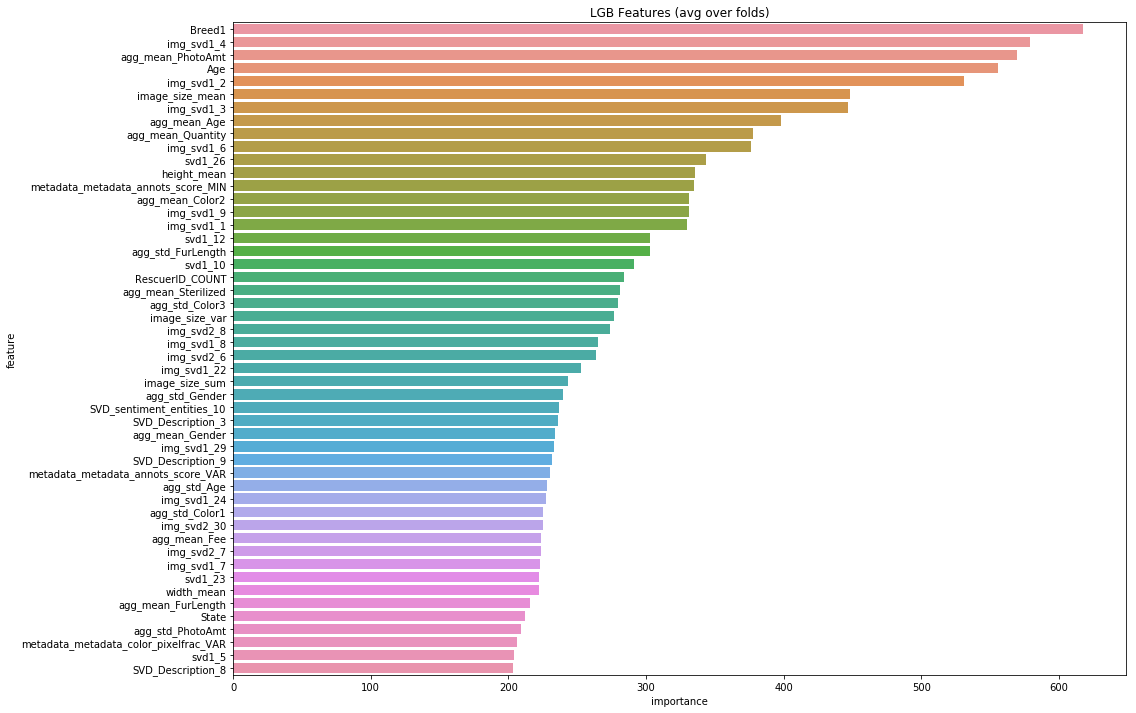

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns 

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

In [91]:
submission = pd.DataFrame({'PetID': pd.read_csv("../input/petfinder-adoption-prediction/test/test.csv")['PetID'].values, 'AdoptionSpeed': test_rounded_lr})

In [92]:
submission.to_csv('submission.csv', index=False)

OSError: [Errno 28] No space left on device